# Rebuild of P5-Matlab-Classificator

### Imports and Variables

In [2]:
import sys
import pandas as pd
import numpy as np
import spectral
import os
import glob
import matplotlib.pyplot as plt
from sklearn import preprocessing
import copy
import tensorflow as tf
from tensorflow import keras  # tf.keras
import matplotlib as mpl
import sklearn
import pickle
import datetime

from data_handling import get_hsi_capture, get_hsi_fullpath, display_roi_rectangle
%load_ext tensorboard

In [3]:
bands = np.linspace(900,1700,224);
root = r"D:\OneDriveFHNW\FHNW\EUT-P6bb-21HS-RS_M365 - General\captures\references"
materials = ["PET", "LDPE", "PS", "PP", "background"]

##### Load images of all 5 types into RAM

In [ ]:
plastic_references = {}
for material in materials:
  if material != "background":
    data = get_hsi_capture(f"{material}_ref", root)
    plastic_references[material] = data.load()

bg_data = get_hsi_fullpath(r"D:\OneDriveFHNW\FHNW\EUT-P6bb-21HS-RS_M365 - General\captures\references\p6bb-rs_PP_referenz_2021-11-16_15-03-58")
plastic_references["background"] = bg_data.load()

##### Define ROIs for data selection and create list containing all ROI-data as 2D-Array

In [5]:
# Tuple with Y-values on pos1, X-values on pos2
ROIs = {
    "PET": ((150,250),(250,350)),
    "PP": ((250,350), (250,350)),
    "LDPE": ((200,300), (300,400)),
    "PS": ((460,500), (170,210)),
    "background": ((650,750), (100,200)), #On PP-capture
}

In [6]:
plastic_rois = {}
for material in materials:
    y1 = ROIs[material][0][0]
    y2 = ROIs[material][0][1]
    x1 = ROIs[material][1][0]
    x2 = ROIs[material][1][1]

    data = plastic_references[material][y1:y2,x1:x2,8:216]
    [m,n,p] = np.shape(data)
    data_reshaped = np.reshape(data,[m*n,p])
    plastic_rois[material] = data_reshaped

    # Uncomment to display images with selected ROIs
    #display_roi_rectangle(plastic_references[material], y1,x1,y2-y1,x2-x1, title=f"Selected ROI of {material}")

##### Scale data to range from 0 to 1

In [21]:
fulldata_unscaled = np.concatenate((list(plastic_rois.values())))
scaler = sklearn.preprocessing.MinMaxScaler()
fulldata_scaled = scaler.fit_transform(fulldata_unscaled)

# Save scaler for use when predicting plastics later
pickle.dump(scaler, open('scalers/scaler_matlab.pkl', 'wb'))

##### Crate labels of the plastic categories for training the ANN

In [ ]:
labels = np.zeros((41600,5))
for i in range(0,10000):
    labels[i][0] = 1

for i in range(10000,20000):
    labels[i][1] = 1

for i in range(20000,21600):
    labels[i][2] = 1

for i in range(21600,31600):
    labels[i][3] = 1

for i in range(31600,41600):
    labels[i][4] = 1

plt.matshow(labels, aspect='auto')
plt.title("Trainingsmatrix", fontdict = {'fontsize' : 36})
plt.rcParams.update({"font.size": 14})

##### Create and compile Tensorflow model using keras

In [10]:
model = keras.models.Sequential(
    [
        keras.layers.Input(208),
        keras.layers.Dense(96, activation="relu"),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(48, activation="relu"),
        keras.layers.Dense(5, activation="softmax"),
    ]
)

model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
    metrics=["accuracy"],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                20064     
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 48)                4656      
                                                                 
 dense_2 (Dense)             (None, 5)                 245       
                                                                 
Total params: 24,965
Trainable params: 24,965
Non-trainable params: 0
_________________________________________________________________


##### Initialize Tensorboard logs and fit model to trainingdata

In [ ]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(fulldata_scaled, labels, epochs=25, callbacks=[callback, tensorboard_callback])

##### Read and prepare data to test model performance

In [13]:
test_capture = get_hsi_fullpath(r"D:\OneDriveFHNW\FHNW\EUT-P5bb-20HS-RS_M365 - Documents\Hyperspektral Kamera\qd_Referenzmaterialien_(oben_nach_unten)_PE_-_PET_-_PP_-_PS_2020-07-10_12-39-11")
test_data = test_capture.load()
[m,n,p] = np.shape(test_data)
testdata_reshaped = np.reshape(test_data, [m*n,p])[:,8:216]
scaler = pickle.load(open('scalers/scaler_matlab.pkl', 'rb'))
testdata_ready = scaler.transform(testdata_reshaped)

##### Run model prediction

In [17]:
result = model.predict(testdata_ready)

17380/17380 [==============================] - 25s 1ms/step


##### Plot the results of the models prediction

In [19]:
%matplotlib qt5
result_class = result.argmax(axis=1)
cmap = mpl.cm.get_cmap("Paired",9)
plt.figure()
plt.imshow(np.reshape(result_class, [m, n]), cmap=cmap)
plt.colorbar()

##### Save or load the tensorflow model 

In [20]:
model.save('./models/model_matlab_classificator_rebuild')
#from tensorflow import keras
#model = keras.models.load_model('./models/model_matlab_classificator_rebuild')

INFO:tensorflow:Assets written to: ./models/model_matlab_classificator_rebuild\assets


INFO:tensorflow:Assets written to: ./models/model_matlab_classificator_rebuild\assets


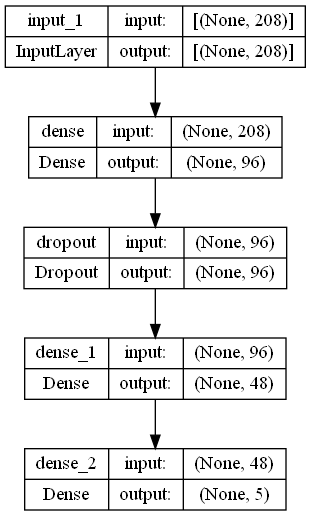

In [1]:
from keras.utils.vis_utils import plot_model
from keras.models import load_model
model = load_model('./models/model_matlab_classificator_rebuild')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)